In [ ]:
#@title Enter your Stability API key

import getpass
# @markdown To get your API key visit https://platform.stability.ai/account/keys
STABILITY_KEY = getpass.getpass('Enter your API Key')

In [12]:
#@title Utility functions definitions
import base64
import requests
from IPython.display import display, HTML
from PIL import Image
from google.colab import output

def display_glb(file_path):
    with open(file_path, "rb") as file:
        glb_base64 = base64.b64encode(file.read()).decode('utf-8')

    html_content = f"""
    <html>
      <head>
        <script src="https://cdnjs.cloudflare.com/ajax/libs/three.js/r128/three.min.js"></script>
        <script src="https://cdn.jsdelivr.net/npm/three@0.128.0/examples/js/loaders/GLTFLoader.js"></script>
        <script src="https://cdn.jsdelivr.net/npm/three@0.128.0/examples/js/controls/OrbitControls.js"></script>
      </head>
      <body>
        <div id="container" style="width: 500px; height: 500px;"></div>
        <script>
          const scene = new THREE.Scene();
          const camera = new THREE.PerspectiveCamera(75, 1, 0.1, 1000);
          const renderer = new THREE.WebGLRenderer({{antialias: true}});
          renderer.setSize(500, 500);
          renderer.setClearColor(0x404040);
          document.getElementById('container').appendChild(renderer.domElement);

          const controls = new THREE.OrbitControls(camera, renderer.domElement);
          controls.enableDamping = true;
          controls.dampingFactor = 0.25;
          controls.enableZoom = true;

          const ambientLight = new THREE.AmbientLight(0xffffff, 0.5);
          scene.add(ambientLight);
          const directionalLight = new THREE.DirectionalLight(0xffffff, 0.6);
          directionalLight.position.set(0.5, 1, -1.5);
          scene.add(directionalLight);

          const loader = new THREE.GLTFLoader();
          const glbData = atob('{glb_base64}');
          const glbBuffer = new Uint8Array(glbData.length);
          for (let i = 0; i < glbData.length; i++) {{
            glbBuffer[i] = glbData.charCodeAt(i);
          }}

          loader.parse(glbBuffer.buffer, '', (gltf) => {{
            scene.add(gltf.scene);

            const box = new THREE.Box3().setFromObject(gltf.scene);
            const center = box.getCenter(new THREE.Vector3());
            const size = box.getSize(new THREE.Vector3());
            const maxDim = Math.max(size.x, size.y, size.z);

            const fov = camera.fov * (Math.PI / 180);
            let cameraZ = Math.abs(maxDim / 2 / Math.tan(fov / 2));
            camera.position.z = cameraZ * -1.5;
            camera.lookAt(center);

            controls.target.copy(center);
            controls.update();

            function animate() {{
              requestAnimationFrame(animate);
              controls.update();
              renderer.render(scene, camera);
            }}
            animate();
          }}, undefined, (error) => {{
            console.error('Error loading GLB:', error);
          }});
        </script>
      </body>
    </html>
    """
    display(HTML(html_content))

def image_to_3d(host, image_path, texture_resolution, foreground_ratio):
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers={"Authorization": f"Bearer {STABILITY_KEY}"},
        files={"image": open(image_path, 'rb')},
        data={
            "foreground_ratio" : foreground_ratio,
            "texture_resolution" : texture_resolution,
        }
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return response

Sending REST request to https://api.stability.ai/v2beta/3d/stable-fast-3d ...
Saved 3D model model.glb


<IPython.core.display.Javascript object>

Original image:


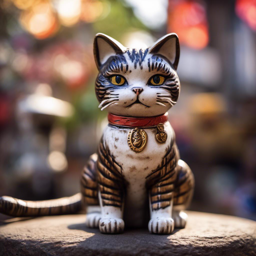

3D model result:


In [11]:
#@title Stable Fast 3D

#@markdown - Drag and drop image to file folder on left
#@markdown - Right click it and choose Copy path
#@markdown - Paste that path into image field below
#@markdown <br><br>

image = "/content/cat_statue.jpg" #@param {type:"string"}
texture_resolution = "1024" #@param ['512', '1024', '2048'] {type:"string"}
foreground_ratio = 0.85 #@param {type:"number"}

host = "https://api.stability.ai/v2beta/3d/stable-fast-3d"

response = image_to_3d(
    host,
    image,
    texture_resolution,
    foreground_ratio
)

# Save the model
filename = f"model.glb"
with open(filename, "wb") as f:
    f.write(response.content)
print(f"Saved 3D model {filename}")

# Display the result
output.no_vertical_scroll()
print("Original image:")
thumb = Image.open(image)
thumb.thumbnail((256, 256))
display(thumb)
print("3D model result:")
display_glb(filename)
